$$ Antoine ~ Andurao$$

# <center>IMA205 - Challenge: Code</center>

<h1>Importing packages and data</h1>

In [42]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from nilearn.image import resample_img
from scipy.ndimage import zoom, distance_transform_edt
from skimage import measure

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Conv3DTranspose

In [78]:
import os
cwd = os.getcwd()

In [79]:
train_ED = glob.glob(cwd + "\Train\*\*ED.nii")
train_ES = glob.glob(cwd + "\Train\*\*ES.nii")
train_ED_seg = glob.glob(cwd + "\Train\*\*ED_seg.nii")
train_ES_seg = glob.glob(cwd + "\Train\*\*ES_seg.nii")

test_ED = glob.glob(cwd + "\Test\*\*ED.nii")
test_ES = glob.glob(cwd + "\Test\*\*ES.nii")
test_ED_seg = glob.glob(cwd + "\Test\*\*ED_seg.nii")
test_ES_seg = glob.glob(cwd + "\Test\*\*ES_seg.nii")

In [26]:
train_data = pd.read_csv(cwd + "/metadataTrain.csv")
test_data = pd.read_csv(cwd + "/metadataTest.csv")
ground_truth = pd.read_csv(cwd + "/ground_truth_gael.csv")

<h1>Pre-processing</h1>

In [6]:
def normalize_and_resample(imgs, target_voxel_size = [1.25, 1.25, 10]):
    '''
    Normalize and resample a list of images.

    This function takes a list of image paths as input and performs normalization and resampling on each image
    to match the recommended voxel size specified by the target_voxel_size parameter. The images are loaded
    using nibabel, normalized using mean and standard deviation, and resampled using the zoom function from
    scipy. The normalized and resampled Nifti1 images are then returned as a list.

    Parameters:
    - imgs (list): A list of image paths.
    - target_voxel_size (list): The recommended voxel size to resample the images to. Default is [1.25, 1.25, 10] : 
      these values are provided by the paper.

    Returns:
    - ret (list): A list of normalized and resampled Nifti1 images.
    '''
    
    # create an empty list to store normalized images
    ret = []

    # loop through each image
    for image_path in imgs:
        # load image using nibabel
        image = nib.load(image_path)

        # get image data as a numpy array
        image_array = image.get_fdata()

        # normalize the image data using mean and standard deviation
        mean = np.mean(image_array)
        std = np.std(image_array)
        normalized_image_array = (image_array - mean) / std
        
        # get current voxel size
        current_voxel_size = image.header.get_zooms()

        # calculate the resampling factor
        resampling_factor = np.divide(current_voxel_size, target_voxel_size)

        # resample the image data
        resampled_normalized_image_array = zoom(normalized_image_array, resampling_factor, order=1)

        # create a new nibabel NIFTI1Image with the normalized image data
        resampled_normalized_image = nib.Nifti1Image(resampled_normalized_image_array, image.affine, image.header)

        # append the normalized image to the list
        ret.append(resampled_normalized_image)
        
    return ret

In [1]:
def resample(imgs, target_voxel_size = [1.25, 1.25, 10]):
    '''
    Resample a list of images.

    This function takes a list of image paths as input and performs resampling on each image to match the 
    recommended voxel size specified by the target_voxel_size parameter. The images are loaded using nibabel, 
    and resampled using the zoom function from scipy. The normalized and resampled Nifti1 images are then 
    returned as a list.

    Parameters:
    - imgs (list): A list of image paths.
    - target_voxel_size (list): The recommended voxel size to resample the images to. Default is [1.25, 1.25, 10] : 
      these values are provided by the paper.

    Returns:
    - ret (list): A list of normalized and resampled Nifti1 images.
    '''
        
    # create an empty list to store resampled images
    ret = []

    # loop through each image
    for image_path in imgs:
        # load image using nibabel
        image = nib.load(image_path)

        # get image data as a numpy array
        image_array = image.get_fdata()
    
        # get current voxel size
        current_voxel_size = image.header.get_zooms()

        # calculate the resampling factor
        resampling_factor = np.divide(current_voxel_size, target_voxel_size)

        # resample the image data
        resampled_image_array = zoom(image_array, resampling_factor, order=1)

        # create a new nibabel NIFTI1Image with the normalized image data
        resampled_image = nib.Nifti1Image(resampled_image_array, image.affine, image.header)

        # append the normalized image to the list
        ret.append(resampled_image)
        
    return ret

In [85]:
train_ED = normalize_and_resample(train_ED)
train_ES = normalize_and_resample(train_ES)
train_ED_seg = resample(train_ED_seg)
train_ES_seg = resample(train_ES_seg)

test_ED = normalize_and_resample(test_ED)
test_ED = normalize_and_resample(test_ES)
test_ED_seg = resample(test_ED_seg)
test_ES_seg = resample(test_ES_seg)

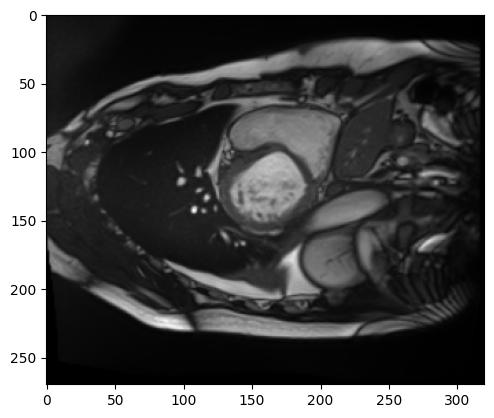

In [86]:
plt.imshow(train_ED[0].get_fdata()[:,:,1], cmap='gray')
plt.savefig(cwd + "/after_preprocessing.png")

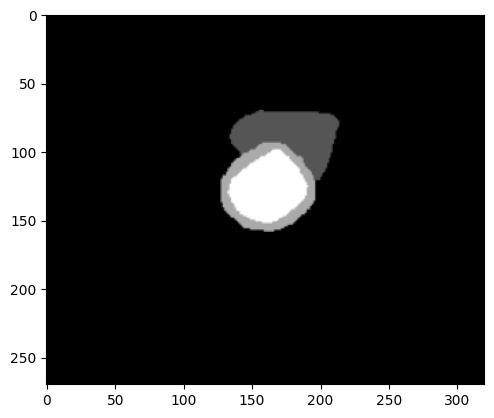

In [11]:
plt.imshow(train_ED_seg[0].get_fdata()[:,:,1], cmap='gray')

<h1>Attempt at segmentation using 3D UNet</h1>

In [87]:
# Define the input shape
input_shape = (None, None, None, 1)

# Define the input layer
inputs = Input(shape=input_shape)

# Define the context aggregation pathway
conv1 = Conv3D(26, kernel_size=(3, 3, 3), padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Conv3D(26, kernel_size=(3, 3, 3), padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 1))(conv1)

conv2 = Conv3D(52, kernel_size=(3, 3, 3), padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Conv3D(52, kernel_size=(3, 3, 3), padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 1))(conv2)

conv3 = Conv3D(104, kernel_size=(3, 3, 3), padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Conv3D(104, kernel_size=(3, 3, 3), padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 1))(conv3)

conv4 = Conv3D(208, kernel_size=(3, 3, 3), padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Conv3D(208, kernel_size=(3, 3, 3), padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling3D(pool_size=(2, 2, 1))(conv4)

conv5 = Conv3D(416, kernel_size=(3, 3, 3), padding='same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Conv3D(416, kernel_size=(3, 3, 3), padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)

# Define the localization pathway
up6 = Conv3DTranspose(208, kernel_size=(2, 2, 1), strides=(2, 2, 1), padding='same')(conv5)
up6 = Concatenate()([up6, conv4])
conv6 = Conv3D(208, kernel_size=(3, 3, 3), padding='same')(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = Conv3D(208, kernel_size=(3, 3, 3), padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

up7 = Conv3DTranspose(104, kernel_size=(2, 2, 1), strides=(2, 2, 1), padding='same')(conv6)
up7 = Concatenate()([up7, conv3])
conv7 = Conv3D(104, kernel_size=(3, 3, 3), padding='same')(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)
conv7 = Conv3D(104, kernel_size=(3, 3, 3), padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)

up8 = Conv3DTranspose(52, kernel_size=(2, 2, 1), strides=(2, 2, 1), padding='same')(conv7)
up8 = Concatenate()([up8, conv2])
conv8 = Conv3D(52, kernel_size=(3, 3, 3), padding='same')(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)
conv8 = Conv3D(52, kernel_size=(3, 3, 3), padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)

up9 = Conv3DTranspose(26, kernel_size=(2, 2, 1), strides=(2, 2, 1), padding='same')(conv8)
up9 = Concatenate()([up9, conv1])
conv9 = Conv3D(26, kernel_size=(3, 3, 3), padding='same')(up9)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)
conv9 = Conv3D(26, kernel_size=(3, 3, 3), padding='same')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)

In [88]:
seg1 = Conv3D(1, kernel_size=(1, 1, 1), activation='sigmoid', name='seg1')(conv3)
seg2 = Conv3D(1, kernel_size=(1, 1, 1), activation='sigmoid', name='seg2')(conv5)
seg3 = Conv3D(1, kernel_size=(1, 1, 1), activation='sigmoid', name='seg3')(conv9)

model = tf.keras.Model(inputs=inputs, outputs=[seg1, seg2, seg3])

In [89]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_36 (Conv3D)             (None, None, None,   728         ['input_3[0][0]']                
                                None, 26)                                                         
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   104        ['conv3d_36[0][0]']              
 ormalization)                  None, 26)                                                   

                                                                                                  
 activation_43 (Activation)     (None, None, None,   0           ['batch_normalization_43[0][0]'] 
                                None, 208)                                                        
                                                                                                  
 max_pooling3d_11 (MaxPooling3D  (None, None, None,   0          ['activation_43[0][0]']          
 )                              None, 208)                                                        
                                                                                                  
 conv3d_44 (Conv3D)             (None, None, None,   2336672     ['max_pooling3d_11[0][0]']       
                                None, 416)                                                        
                                                                                                  
 batch_nor

 ormalization)                  None, 52)                                                         
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
                                None, 52)                                                         
                                                                                                  
 conv3d_51 (Conv3D)             (None, None, None,   73060       ['activation_50[0][0]']          
                                None, 52)                                                         
                                                                                                  
 batch_normalization_51 (BatchN  (None, None, None,   208        ['conv3d_51[0][0]']              
 ormalization)                  None, 52)                                                         
          

In [15]:
# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss)

# Define the learning rate decay schedule
def lr_decay(epoch):
    return 5e-4 * (0.98 ** epoch)

# Define the callbacks
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_decay),
    tf.keras.callbacks.ModelCheckpoint('3D_model_weights.h5', save_best_only=True, save_weights_only=True)
]

# Get validation data
train_data_seg = [nib.load(train_ED_seg[i]).get_fdata().tolist() for i in range(len(train_ED_seg))]
train_data = [resampled_train_ED[i].get_fdata() for i in range(len(train_ED_seg))]

# Train the model for 300 epochs with a batch size of 4
history = model.fit(train_data, epochs=3, steps_per_epoch=300, batch_size=4, validation_data=train_data_seg, callbacks=callbacks)

train_acc_N = history.history['accuracy']
print(train_acc_N)

<h1>Feature extraction</h1>

In [12]:
def get_binary_from_multiclass(mask_array, selected_class):
    '''
    Convert the mask array to a binary array.
    
    Description:
        This method takes a mask array and a selected class as input and converts the mask array into a binary array.
        It assigns a value of 1 to pixels where the mask array is equal to the selected class, and a value of 0 to pixels where the mask array is not equal to the selected class. 
        The resulting binary array is then converted to a boolean data type.

    Parameters:

        mask_array (ndarray): The input mask array.
        selected_class (int or ndarray): The selected class to be converted to binary.

    Returns:
        binary_array (ndarray): The binary array obtained from the mask array, where pixels with the selected class are set to 1 and others are set to 0.
    '''

    # Convert the mask array to a binary array
    binary_array = np.zeros_like(mask_array)
    binary_array[np.where(mask_array == selected_class)] = 1
    binary_array[np.where(mask_array != selected_class)] = 0

    # Ensure that the binary array is of dtype bool
    binary_array = binary_array.astype(bool)
    return binary_array

In [13]:
def fit_circle_to_contour(contour):
    '''
    Fit a circle to a contour using least-squares fitting.

    This method fits a circle to a contour represented by a set of points using least-squares fitting.
    It calculates the center coordinates (x, y) and the radius of the fitted circle.

    Parameters:
    - contour (ndarray): The contour points represented as an array of shape (n, 2), where n is the number of points.
                         Each point should be in the format (x, y).

    Returns:
    - center_x (float): The x-coordinate of the center of the fitted circle.
    - center_y (float): The y-coordinate of the center of the fitted circle.
    - radius (float): The radius of the fitted circle.
    '''
    
    # Fit a circle to the contour points using least-squares fitting
    x, y = contour[:, 1], contour[:, 0]
    A = np.column_stack([x**2 + y**2, x, y, np.ones_like(x)])
    b = -(x**2 + y**2)
    c = np.linalg.lstsq(A, b, rcond=None)[0]
    
    # Extract center and radius of the fitted circle
    center_x, center_y = -c[1]/2, -c[2]/2
    radius = np.sqrt((c[1]**2 + c[2]**2)/4 - c[0])
    
    return center_x, center_y, radius

In [14]:
def circumference_circularity_LVM_RVC(lvm_mask, rvc_mask):
    '''
    Compute circumference and circularity metrics for Left Ventricular Myocardium (LVM) and Right Ventricle (RVC).

    This method takes binary masks of LVM and RVC regions as input and computes various metrics including
    circumference, circularity, thickness, and area for each region.

    Parameters:
    - lvm_mask (ndarray): Binary mask of the LVM region.
    - rvc_mask (ndarray): Binary mask of the RVC region.

    Returns:
    - metrics (list): A list containing the following metrics in the specified order:
                      [lvm_circumference, lvm_circularity, lvm_thickness, lvm_area,
                       rvc_circumference, rvc_circularity, rvc_thickness, rvc_area]
    '''
    
    # Compute the contours of the LVM and RVC
    lvm_contours = measure.find_contours(lvm_mask, 0.5)
    rvc_contours = measure.find_contours(rvc_mask, 0.5)
    
    if(len(lvm_contours) != 0):

        # Fit a circle to the contour points of LVM region
        lvm_center_x, lvm_center_y, lvm_radius = fit_circle_to_contour(lvm_contours[0])
        
        # Compute circumference and circularity of LVM region
        lvm_circumference = 2 * np.pi * lvm_radius
        lvm_area = np.sum(lvm_mask == 1)
        lvm_circularity = (4 * np.pi * lvm_area) / (lvm_circumference ** 2)
        
        # Compute distance transform of the binary mask
        dist_transform = distance_transform_edt(lvm_mask == 0)
        
        # Compute thickness of LVM region
        lvm_thickness = dist_transform[int(lvm_center_x), int(lvm_center_y)] - lvm_radius
    else:
        lvm_circumference, lvm_circularity, lvm_thickness, lvm_area = 0, 0, 0, 0
    
    if(len(rvc_contours) != 0):
        
        # Fit a circle to the contour points of RVC region
        rvc_center_x, rvc_center_y, rvc_radius = fit_circle_to_contour(rvc_contours[0])
        
        # Compute circumference and circularity of RVC region
        rvc_circumference = 2 * np.pi * rvc_radius
        rvc_area = np.sum(rvc_mask == 1)
        rvc_circularity = (4 * np.pi * rvc_area) / (rvc_circumference ** 2)
        
        # Compute distance transform of the binary mask
        dist_transform = distance_transform_edt(rvc_mask == 0)

        # Compute thickness of RVC region
        rvc_thickness = dist_transform[int(rvc_center_x), int(rvc_center_y)] - rvc_radius
    else:
        rvc_circumference, rvc_circularity, rvc_thickness, rvc_area = 0, 0, 0, 0
    
    return [lvm_circumference, lvm_circularity, lvm_thickness, lvm_area, rvc_circumference, rvc_circularity, rvc_thickness, rvc_area]

In [15]:
def aggregate_features_over_z(img, feat_func):
    '''
    Aggregate features over the z-dimension of an Nifti1 image.

    This method takes a Nifti1 image and a feature function as input and aggregates the features computed by the
    feature function over the z-dimension of the image. The feature function should take binary masks of
    Left Ventricular Myocardium (LVM) and Right Ventricle (RVC) regions as input and return a list of metrics.

    Parameters:
    - img (Nifti1Image): The input image.
    - feat_func (function): The feature function to compute metrics for LVM and RVC regions.

    Returns:
    - aggregated_features (ndarray): An array containing the aggregated features over the z-dimension.
    '''
    
    img_data = img.get_fdata()
    num_z_planes = img_data.shape[2]
    circ_features = []
    for i in range(num_z_planes):
        rvc_mask = get_binary_from_multiclass(img_data[:,:,i], 1)
        lvm_mask = get_binary_from_multiclass(img_data[:,:,i], 2)
        
        circ_features.append(feat_func(lvm_mask, rvc_mask))
        
    aggregated_features = np.mean(circ_features, axis=0)
    
    return aggregated_features

In [16]:
def get_features(ES_imgs, ED_imgs, data):
    '''
    Get features for a set of Nifti1 images and corresponding data.

    This method takes a list of end-systolic (ES) images, end-diastolic (ED) images, and corresponding data
    as input. It computes features for each image using the aggregate_features_over_z method and returns
    a numpy array containing the computed features concatenated with Body Surface Area (BSA) values from
    the provided data.
    
    BSA is computed using Mosteller formula.

    Parameters:
    - ES_imgs (list): A list of end-systolic images.
    - ED_imgs (list): A list of end-diastolic images.
    - data (DataFrame): Data containing additional information for each Nifti1 image.

    Returns:
    - features_tab (ndarray): An array containing a set of 17 features for each pair of ED-ES Nifti1 images.
    '''
    
    features_tab = []
    for i in range(len(ES_imgs)):
        circ_and_thick_features_ED = aggregate_features_over_z(ED_imgs[i], circumference_circularity_LVM_RVC)
        circ_and_thick_features_ES = aggregate_features_over_z(ES_imgs[i], circumference_circularity_LVM_RVC)
        BSA = [np.sqrt((data.loc[i, 'Height'] * data.loc[i, 'Weight']) / 3600)]
        features_tab.append(np.concatenate((circ_and_thick_features_ES, circ_and_thick_features_ED, BSA)))
    return np.array(features_tab)
        

<h1>Classification</h1>

**Retrieving the features and shuffling data**

In [29]:
X_train = get_features(train_ES_seg, train_ED_seg, train_data)
X_test = get_features(test_ES_seg, test_ED_seg, test_data)

In [34]:
y_train = np.array(train_data['Category'])
y_test = np.array(ground_truth['Category'])

In [35]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

**K-NN Classifier**

In [66]:
neigh = KNeighborsClassifier()

p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_result = grid_KNN.predict(X_test)

Best training Score: 0.6499999999999999
Best training params: {'n_neighbors': 10}


**SVM - Linear and Non-Linear**

In [67]:
# Looking for the best hyperparameters
svc = SVC()

p_grid_SVC = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}
p_grid_SVC = GridSearchCV(estimator=svc, param_grid=p_grid_SVC, scoring="accuracy", cv=5)
p_grid_SVC.fit(X_train, y_train)
print("Best training Score: {}".format(p_grid_SVC.best_score_))
print("Best training params: {}".format(p_grid_SVC.best_params_))
y_result = p_grid_SVC.predict(X_test)

Best training Score: 0.67
Best training params: {'kernel': 'rbf'}


**RandomForest Classifier**

In [69]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="balanced_accuracy", cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
y_result = grid_RF.predict(X_test)

Best Validation Score: 0.62
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 20}


**Saving the results for submission**

In [284]:
data = {"Id": test_data["Id"], "Category": y_result}
res = pd.DataFrame(data)
res.to_csv("ANDURAO_SUBMISSION_3.csv", index=False)